In [57]:
import sys, glob, yaml
sys.path.append('../toolbox/')
sys.path.append('../weld')
from lambda_calc import *
from multi_robot import *
from dx200_motion_program_exec_client import *
from WeldSend import *
from RobotRaconteur.Client import *
from weldRRSensor import *
from motoman_def import *
from flir_toolbox import *
import weld_dh2v
import matplotlib.pyplot as plt
from datetime import datetime
import re

def get_trailing_number(s):
    m = re.search(r'\d+$', s)
    return int(m.group()) if m else None

layer = 1
x=0

dataset='bent_tube/'
sliced_alg='slice_ER_4043_dense/'
data_dir='../data/'+dataset+sliced_alg

def flame_detection_aluminum(raw_img,threshold=1.0e4,area_threshold=4,percentage_threshold=0.8):
    ###flame detection by raw counts thresholding and connected components labeling
    #centroids: x,y
    #bbox: x,y,w,h
    ###adaptively increase the threshold to 60% of the maximum pixel value
    threshold=max(threshold,percentage_threshold*np.max(raw_img))
    thresholded_img=(raw_img>threshold).astype(np.uint8)

    nb_components, labels, stats, centroids = cv2.connectedComponentsWithStats(thresholded_img, connectivity=4)
    
    valid_indices=np.where(stats[:, cv2.CC_STAT_AREA] > area_threshold)[0][1:]  ###threshold connected area
    if len(valid_indices)==0:
        return None, None, None, None
    
    average_pixel_values = [np.mean(raw_img[labels == label]) for label in valid_indices]   ###sorting
    valid_index=valid_indices[np.argmax(average_pixel_values)]      ###get the area with largest average brightness value

    # Extract the centroid and bounding box of the largest component
    centroid = centroids[valid_index]
    bbox = stats[valid_index, :-1]

    return centroid, bbox

robot=robot_obj('MA2010_A0',def_path='../config/MA2010_A0_robot_default_config.yml',tool_file_path='../config/torch.csv',\
	pulse2deg_file_path='../config/MA2010_A0_pulse2deg_real.csv',d=15)
robot2=robot_obj('MA1440_A0',def_path='../config/MA1440_A0_robot_default_config.yml',tool_file_path='../config/flir.csv',\
	pulse2deg_file_path='../config/MA1440_A0_pulse2deg_real.csv',base_transformation_file='../config/MA1440_pose.csv')
positioner=positioner_obj('D500B',def_path='../config/D500B_robot_extended_config.yml',tool_file_path='../config/positioner_tcp.csv',\
	pulse2deg_file_path='../config/D500B_pulse2deg_real.csv',base_transformation_file='../config/D500B_pose.csv')

config_dir='../config/'
flir_intrinsic=yaml.load(open(config_dir+'FLIR_A320.yaml'), Loader=yaml.FullLoader)

layer = 108
save_path = f'../../recorded_data/ER4043_bent_tube_2024_07_18_13_37_40/layer_{layer}/'
with open(save_path+'ir_recording.pickle', 'rb') as file:
        ir_recording = pickle.load(file)

plate_offset = 12.44 #mm

H = np.loadtxt(data_dir+'curve_pose.csv', delimiter=',')
print(H)

[[-2.46887427e-01 -9.69044167e-01  0.00000000e+00  8.85847192e-16]
 [ 9.69044167e-01 -2.46887427e-01  0.00000000e+00  3.72339150e-16]
 [-0.00000000e+00 -0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [58]:
flame_3d=[]
job_no = []
ir_ts=np.loadtxt(save_path+'ir_stamps.csv', delimiter=',')
if len(ir_ts)>0:
    joint_angle=np.loadtxt(save_path+'weld_js_exe.csv', delimiter=',')

    timeslot=[ir_ts[0]-ir_ts[0], ir_ts[-1]-ir_ts[0]]
    duration=np.mean(np.diff(timeslot))


    for start_time in timeslot[:-1]:
        
        start_idx=np.argmin(np.abs(ir_ts-ir_ts[0]-start_time))
        end_idx=np.argmin(np.abs(ir_ts-ir_ts[0]-start_time-duration))
        print(start_idx)
        print(end_idx)

        #find all pixel regions to record from flame detection
        for i in range(start_idx,end_idx):
            
            ir_image = ir_recording[i]
            try:
                centroid, bbox=flame_detection_aluminum(ir_image, percentage_threshold=0.8)
            except ValueError:
                centroid = None
            if centroid is not None:
                #find spatial vector ray from camera sensor
                vector=np.array([(centroid[0]-flir_intrinsic['c0'])/flir_intrinsic['fsx'],(centroid[1]-flir_intrinsic['r0'])/flir_intrinsic['fsy'],1])
                vector=vector/np.linalg.norm(vector)
                #find index closest in time of joint_angle
                joint_idx=np.argmin(np.abs(ir_ts[i]-joint_angle[:,0]))
                robot2_pose_world=robot2.fwd(joint_angle[joint_idx][8:-2],world=True)
                p2=robot2_pose_world.p
                v2=robot2_pose_world.R@vector
                robot1_pose=robot.fwd(joint_angle[joint_idx][2:8])
                p1=robot1_pose.p
                v1=robot1_pose.R[:,2]
                positioner_pose=positioner.fwd(joint_angle[joint_idx][-2:], world=True)

                #find intersection point
                intersection=line_intersect(p1,v1,p2,v2)
                # Convert to positioner frame
                
                intersection = positioner_pose.R@(intersection-(positioner_pose.p))

                flame_3d.append(intersection)
                job_no.append(int(joint_angle[joint_idx][1]))
flame_3d = np.array(flame_3d)

0
896


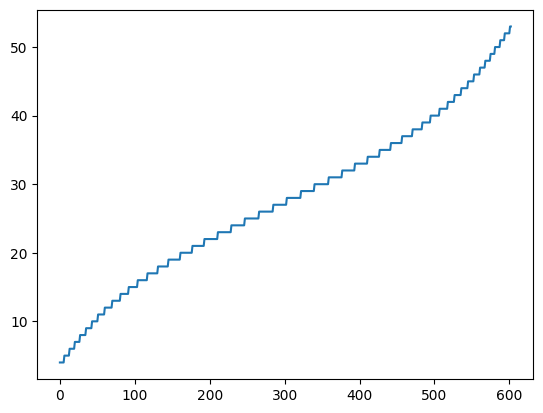

Min Job no:  4
Max Job no:  53
Job Len:  603
Flame len:  603


In [59]:
plt.plot(job_no)
plt.show()
print("Min Job no: ", job_no[0])
print("Max Job no: ", job_no[-1])
print("Job Len: ", len(job_no))
print("Flame len: ", len(flame_3d))

In [62]:
p = H[:3, -1]
R = H[:3, :3]
R_inv = np.linalg.inv(R)
flame_3d[:, -1] = flame_3d[:, -1]-plate_offset
#convert back to designed part frame
for i in range(flame_3d.shape[0]):
    flame_3d[i] = R_inv@flame_3d[i]


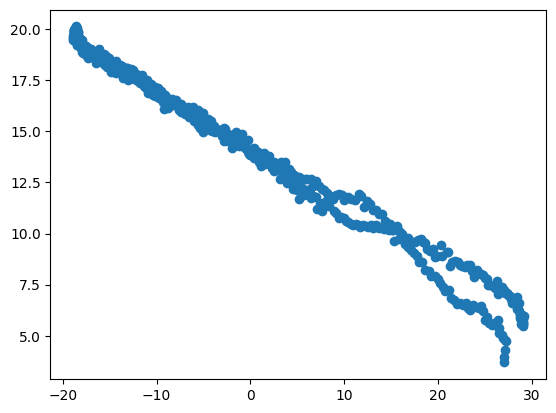

In [64]:

plt.scatter(flame_3d[:,1], flame_3d[:, -1])
plt.show()